# Predicting mid-career salary based on education data

For this example we employ three datasets:

- One containing data sourced form the Wall Street Journal that analyzes salaries by college, region and academic major.
- A dataset compiled and shared through Kaggle, containing attributes related to many of the same colleges and universities as in the dataset above.
- Data from the College Scorecard published by the U.S. Department of Education.

Using this dataset we fit a multiclass logistic regression model that classifies students into likely salary brackets they will reach mid-career, depending on which school, major and other factors are applicable to each.

In [1]:
import sys
sys.path.insert(0, '../LIMEaid/controller')
sys.path.insert(0, '../LIMEaid/model')
sys.path.insert(0, '../LIMEaid/view')
import fit_sklearn_models as fsm
import LIMEaid as la
import LIMEdisplay as ld
import load_college_dataset as gcd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn import tree

# Number of perturbed samples to be generated.
n = 100000
# Number of bins for the histograms of continous attributes.
num_bins = 25

The functions below merge and prepare the data, after uploading it, and leave it ready for us to fit the logistic regression model.

In [2]:
college = gcd.load_college_dataset()
features = list(college)[1:]
salary_class = np.array(college.iloc[:, 0])
college = np.array(college.iloc[:, 1:])

<_io.TextIOWrapper name='C:\\Users\\Castor18\\OneDrive\\MSDS_UW\\Data515_Spr19_Sw_Eng\\myproject\\LIMEaid\\LIMEaid\\model\\../data/Most-_Recent-_Cohorts-_Scorecard-_Elements.csv' mode='r' encoding='cp1252'>


Next we fit the logistic regression model.

In [3]:
clf = fsm.fit_multiclass_logistic_regression()

<_io.TextIOWrapper name='C:\\Users\\Castor18\\OneDrive\\MSDS_UW\\Data515_Spr19_Sw_Eng\\myproject\\LIMEaid\\LIMEaid\\model\\../data/Most-_Recent-_Cohorts-_Scorecard-_Elements.csv' mode='r' encoding='cp1252'>


## Interpreting the output of the Logistic Regression model using LIME.

We now take the dataset, attributes only, and form them we generate n random samples with similar distributions in the values of each attribute.

In [4]:
# Note that, unlike the Iris example where all attributes had continuous
# values, in this dataset the first attribute has discrete values. So, we
# call lime_sample setting the "continuous" parameter, second one in the
# call, to False.
perturbed_samples = la.lime_sample(n, False, college[:, 0], num_bins)
# The for loop calls lime_sample for each of the remaining attributes,
# setting the "continuous" parameter to True.
for j in range(1, college.shape[1]):
    array = college[:, j]
    output = la.lime_sample(n, True, array, num_bins)
    perturbed_samples = np.vstack((perturbed_samples, output))
perturbed_samples = np.transpose(perturbed_samples)

Once random samples with the right distributions for each attribute have been generated, we provide them as input to the Logistic Regression model we fitted earlier, and obtain the classification for each.

In [5]:
class_perturb_samples = clf.predict(perturbed_samples)

We select a single instance from the dataset. This is the instance we will try to interpret using LIME.

In [6]:
# Normalizing the data.
college_norm = preprocessing.scale(college)
# Selecting the instance to interpret.
inst_num = np.round(np.random.uniform(0, college_norm.shape[0], 1))
inst_num = inst_num[0].astype(int)
# x is the selected instance, and x_class is the class assigned
# by the decision tree. 
x = college_norm[inst_num, :]
x_class = salary_class[inst_num]

## Calling LIME function to get intepretation.

In [7]:
# We now fit the LIME linear model to get the coefficients and
# intercept, as well as the weight of each random sample, 
# based on its L2 distance to the instance that is being
# interpreted.
lime_beta, lime_int, lime_weigh = la.lime_fit(x,
                                              x_class,
                                              perturbed_samples,
                                              class_perturb_samples)

## Intepreting the results

Below we present the results obtained from the LIME linear regression model, and identify those attributes that played a significant role in the classification that was assigned to each instance by the Logistic Regression classifier. 

In [8]:
# Print output of LIME results.
# First list the attributes and values for the instance
# we are looking at.
print("Instance to be interpreted:")
for j in range(0, len(lime_beta)):
    print("Feature: ", features[j], "\tvalue: ",
          college[inst_num, j], "\tnormalized value: ",
          college_norm[inst_num, j])
print("Classification: ", x_class)
# Second we list the attributes that LIME has
# identified as significant in this case, along with
# the corresponding LIME coefficients and the LIME
# intercept.
print("\nSignificant coefficients from LIME adjusted"
      " linear model:")
significant_attributes = 0
for j in range(0, len(lime_beta)):
    if(lime_beta[j] != 0):
        significant_attributes = np.append(significant_attributes, j)
        print("Feature: ", features[j],
              "\tCoefficient: ", lime_beta[j])
significant_attributes = significant_attributes[1:]
print("Intercept: ", lime_int)

Instance to be interpreted:
Feature:  HCM2 	value:  0.0 	normalized value:  0.0
Feature:  SATVR25 	value:  610.0 	normalized value:  0.8279109045530632
Feature:  SATVR75 	value:  710.0 	normalized value:  0.827887130425389
Feature:  SATMT25 	value:  620.0 	normalized value:  0.7527182896284788
Feature:  SATMT75 	value:  720.0 	normalized value:  0.7617365530839537
Feature:  SATWR25 	value:  630.0 	normalized value:  1.0394908779151995
Feature:  SATWR75 	value:  710.0 	normalized value:  0.7710461150749859
Feature:  ACTCM25 	value:  28.0 	normalized value:  0.9532444604150984
Feature:  ACTCM75 	value:  32.0 	normalized value:  0.9689035793685704
Feature:  ACTEN25 	value:  28.0 	normalized value:  1.1968140340296447
Feature:  ACTEN75 	value:  33.0 	normalized value:  1.1624138601596006
Feature:  ACTMT25 	value:  27.0 	normalized value:  1.1435900194808717
Feature:  ACTMT75 	value:  32.0 	normalized value:  1.1577354446778019
Feature:  ACTWR25 	value:  7.408163265306122 	normalized value:

If the number of significant attributes in the interpretation of a particular instance is equal to two, we plot the random samples and the instance that is being interpreted on a cathesian plane. In some cases, classes can be separated for the most part by looking at the two selected attributes. Note that those random samples that were classified differently from the instance we are interpreting are merged into a single out-of-class representation.

Finally, we plot the output of the fitted LIME Linear Regression model for each sample, against its class, as yielded by the Logistic Regression model and see that, in most cases, the classes can be differentiated using this model only.

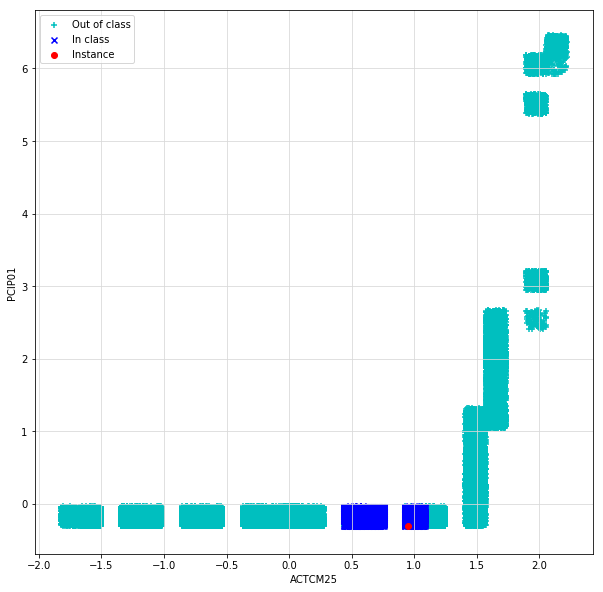

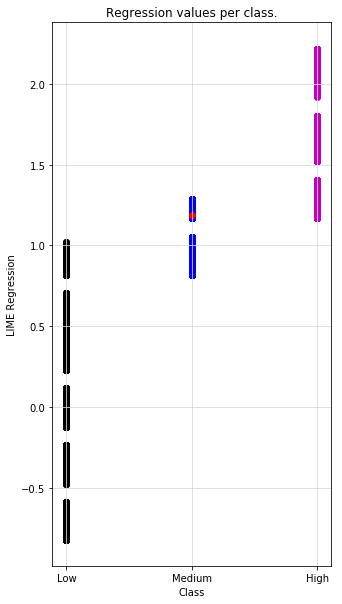

In [9]:
full_data = np.column_stack((perturbed_samples,
                             class_perturb_samples))
ld.lime_display(full_data, lime_beta, lime_int, x, x_class, features,
                ['Low', 'Medium', 'High'])